**FlickPicks** aims to recommend movies that you'll enjoy based on the preferences of similar users. It leverages a technique called **Collaborative filtering**, which analyzes user-movie interaction data to find patterns in taste.

**Step 1: Importing all required Libraries**

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity


***Step 2: Access the dataset and read it ***

In [3]:
ratings=pd.read_csv("/content/ratings.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
print("The ratings dataset has",ratings['userId'].nunique(),"unique users")
print("The ratings dataset has",ratings['movieId'].nunique(),"unique movies")
print("The ratings dataset has",ratings['rating'].nunique(),"unique ratings")
print("The unique ratings are",sorted(ratings['rating'].unique()))

The ratings dataset has 610 unique users
The ratings dataset has 9724 unique movies
The ratings dataset has 10 unique ratings
The unique ratings are [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


In [7]:
movies=pd.read_csv("/content/movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [9]:
df=pd.merge(ratings,movies,on='movieId',how='inner')
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


**Step 3:Preprocess the data **

In [10]:
# Aggregate by movie
agg_ratings = df.groupby('title').agg(mean_rating = ('rating', 'mean'),
                                                number_of_ratings = ('rating', 'count')).reset_index()

# Keep the movies with over 100 ratings
agg_ratings_GT100 = agg_ratings[agg_ratings['number_of_ratings']>100]
agg_ratings_GT100.info()

<class 'pandas.core.frame.DataFrame'>
Index: 134 entries, 74 to 9615
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              134 non-null    object 
 1   mean_rating        134 non-null    float64
 2   number_of_ratings  134 non-null    int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 4.2+ KB


In [11]:
# Check popular movies
agg_ratings_GT100.sort_values(by='number_of_ratings', ascending=False).head()

,title,mean_rating,number_of_ratings
3158,Forrest Gump (1994),4.164134,329
7593,"Shawshank Redemption, The (1994)",4.429022,317
6865,Pulp Fiction (1994),4.197068,307
7680,"Silence of the Lambs, The (1991)",4.161290,279
5512,"Matrix, The (1999)",4.192446,278


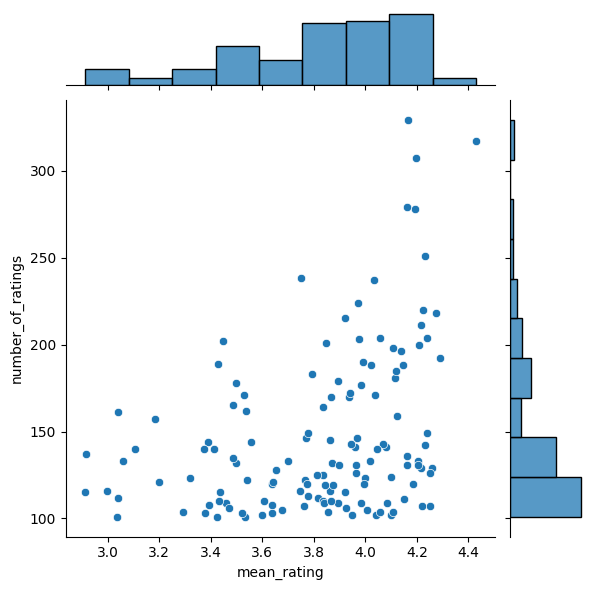

In [12]:
sns.jointplot(x='mean_rating', y='number_of_ratings', data=agg_ratings_GT100)

In [13]:
# Merge data
df_GT100 = pd.merge(df, agg_ratings_GT100[['title']], on='title', how='inner')
df_GT100.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19788 entries, 0 to 19787
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userId     19788 non-null  int64  
 1   movieId    19788 non-null  int64  
 2   rating     19788 non-null  float64
 3   timestamp  19788 non-null  int64  
 4   title      19788 non-null  object 
 5   genres     19788 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 927.7+ KB


In [14]:
# Number of users
print('The ratings dataset has', df_GT100['userId'].nunique(), 'unique users')

# Number of movies
print('The ratings dataset has', df_GT100['movieId'].nunique(), 'unique movies')

# Number of ratings
print('The ratings dataset has', df_GT100['rating'].nunique(), 'unique ratings')

# List of unique ratings
print('The unique ratings are', sorted(df_GT100['rating'].unique()))

The ratings dataset has 597 unique users
The ratings dataset has 134 unique movies
The ratings dataset has 10 unique ratings
The unique ratings are [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


**Step 4: Create User-Movie Matrix**

In [15]:
# Create user-item matrix
matrix = df_GT100.pivot_table(index='userId', columns='title', values='rating')
matrix.head()

title,2001: A Space Odyssey (1968),Ace Ventura: Pet Detective (1994),Aladdin (1992),Alien (1979),Aliens (1986),"Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",American Beauty (1999),American History X (1998),American Pie (1999),Apocalypse Now (1979),...,True Lies (1994),"Truman Show, The (1998)",Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Twister (1996),Up (2009),"Usual Suspects, The (1995)",WALL·E (2008),Waterworld (1995),Willy Wonka & the Chocolate Factory (1971),X-Men (2000)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,4.0,NaN,NaN,5.0,5.0,NaN,4.0,...,NaN,NaN,NaN,3.0,NaN,5.0,NaN,NaN,5.0,5.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,4.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,...,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN
5,NaN,3.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN


**Step 5: Normalizing Data**

In [16]:
# Normalize user-item matrix
matrix_norm = matrix.subtract(matrix.mean(axis=1), axis = 'rows')
matrix_norm.head()

title,2001: A Space Odyssey (1968),Ace Ventura: Pet Detective (1994),Aladdin (1992),Alien (1979),Aliens (1986),"Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",American Beauty (1999),American History X (1998),American Pie (1999),Apocalypse Now (1979),...,True Lies (1994),"Truman Show, The (1998)",Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Twister (1996),Up (2009),"Usual Suspects, The (1995)",WALL·E (2008),Waterworld (1995),Willy Wonka & the Chocolate Factory (1971),X-Men (2000)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,-0.392857,NaN,NaN,0.607143,0.607143,NaN,-0.392857,...,NaN,NaN,NaN,-1.392857,NaN,0.607143,NaN,NaN,0.607143,0.607143
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,0.617647,NaN,NaN,NaN,1.617647,NaN,NaN,NaN,...,NaN,NaN,-1.382353,NaN,NaN,NaN,NaN,NaN,0.617647,NaN
5,NaN,-0.461538,0.538462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.461538,NaN,NaN,NaN,NaN,0.538462,NaN,NaN,NaN,NaN


**Step 6:Using Pearson Correlation to identify similar users**

In [17]:
# User similarity matrix using Pearson correlation
user_similarity = matrix_norm.T.corr()
user_similarity.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,NaN,NaN,0.391797,0.180151,-0.439941,-0.029894,0.464277,1.0,-0.037987,...,0.091574,0.254514,0.101482,-0.500000,0.780020,0.303854,-0.012077,0.242309,-0.175412,0.071553
2,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,...,-0.583333,NaN,-1.000000,NaN,NaN,0.583333,NaN,-0.229416,NaN,0.765641
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.391797,NaN,NaN,1.000000,-0.394823,0.421927,0.704669,0.055442,NaN,0.360399,...,-0.239325,0.562500,0.162301,-0.158114,0.905134,0.021898,-0.020659,-0.286872,NaN,-0.050868
5,0.180151,NaN,NaN,-0.394823,1.000000,-0.006888,0.328889,0.030168,NaN,-0.777714,...,0.000000,0.231642,0.131108,0.068621,-0.245026,0.377341,0.228218,0.263139,0.384111,0.040582


***Input the userId to recommend ***

In [24]:
# Pick a user ID
picked_userid = 2

# Remove picked user ID from the candidate list
user_similarity.drop(index=picked_userid, inplace=True)

# Take a look at the data
user_similarity.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.391797,NaN,NaN,1.000000,-0.394823,0.421927,0.704669,0.055442,NaN,0.360399,...,-0.239325,0.562500,0.162301,-0.158114,0.905134,0.021898,-0.020659,-0.286872,NaN,-0.050868
5,0.180151,NaN,NaN,-0.394823,1.000000,-0.006888,0.328889,0.030168,NaN,-0.777714,...,0.000000,0.231642,0.131108,0.068621,-0.245026,0.377341,0.228218,0.263139,0.384111,0.040582
6,-0.439941,NaN,NaN,0.421927,-0.006888,1.000000,0.000000,-0.127385,NaN,0.957427,...,-0.292770,-0.030599,-0.123983,-0.176327,0.063861,-0.468008,0.541386,-0.337129,0.158255,-0.030567
7,-0.029894,NaN,NaN,0.704669,0.328889,0.000000,1.000000,0.220416,0.816497,-0.349835,...,-0.116141,0.110432,0.290485,0.560968,0.351779,0.154338,0.374808,0.058785,0.420288,-0.043057


In [25]:
# Number of similar users
n = 10

# User similarity threashold
user_similarity_threshold = 0.3

# Get top n similar users
similar_users = user_similarity[user_similarity[picked_userid]>user_similarity_threshold][picked_userid].sort_values(ascending=False)[:n]

# Print out top n similar users
print(f'The similar users for user {picked_userid} are', similar_users)

The similar users for user 2 are userId
10     1.0
203    1.0
184    1.0
159    1.0
112    1.0
93     1.0
363    1.0
370    1.0
313    1.0
60     1.0
Name: 2, dtype: float64


In [26]:
# Movies that the target user has watched
picked_userid_watched = matrix_norm[matrix_norm.index == picked_userid].dropna(axis=1, how='all')
picked_userid_watched

title,"Dark Knight, The (2008)","Departed, The (2006)",Gladiator (2000),Good Will Hunting (1997),Inception (2010),Kill Bill: Vol. 1 (2003),"Shawshank Redemption, The (1994)"
userId,,,,,,,
2,0.5,0.0,0.0,0.5,0.0,0.0,-1.0


In [27]:
# Movies that similar users watched. Remove movies that none of the similar users have watched
similar_user_movies = matrix_norm[matrix_norm.index.isin(similar_users.index)].dropna(axis=1, how='all')
similar_user_movies

title,2001: A Space Odyssey (1968),Aladdin (1992),Alien (1979),Aliens (1986),"Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",American Beauty (1999),American History X (1998),American Pie (1999),Apocalypse Now (1979),Apollo 13 (1995),...,Trainspotting (1996),True Lies (1994),Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Twister (1996),Up (2009),"Usual Suspects, The (1995)",WALL·E (2008),Waterworld (1995),Willy Wonka & the Chocolate Factory (1971),X-Men (2000)
userId,,,,,,,,,,,,,,,,,,,,,
10,NaN,0.921053,NaN,NaN,NaN,-2.078947,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.921053,NaN,NaN,NaN,NaN,NaN
60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-1.400000,NaN,NaN,NaN,NaN
93,NaN,-0.647059,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.352941,...,NaN,0.352941,NaN,-0.647059,NaN,NaN,NaN,NaN,NaN,NaN
112,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.210526,...,-0.289474,NaN,1.210526,NaN,0.210526,1.210526,NaN,-1.289474,NaN,NaN
159,NaN,NaN,NaN,NaN,NaN,0.700000,NaN,NaN,NaN,0.700000,...,NaN,NaN,NaN,NaN,-0.300000,NaN,-1.3,NaN,NaN,NaN
184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.50
203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
313,-0.75,NaN,0.25,1.25,NaN,0.250000,NaN,NaN,0.25,NaN,...,NaN,1.250000,0.250000,NaN,NaN,1.250000,NaN,NaN,-0.75,-0.75
363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.416667,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.583333,NaN,NaN,NaN,NaN


In [28]:
# Remove the watched movie from the movie list
similar_user_movies.drop(picked_userid_watched.columns,axis=1, inplace=True, errors='ignore')

# Take a look at the data
similar_user_movies

title,2001: A Space Odyssey (1968),Aladdin (1992),Alien (1979),Aliens (1986),"Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",American Beauty (1999),American History X (1998),American Pie (1999),Apocalypse Now (1979),Apollo 13 (1995),...,Trainspotting (1996),True Lies (1994),Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Twister (1996),Up (2009),"Usual Suspects, The (1995)",WALL·E (2008),Waterworld (1995),Willy Wonka & the Chocolate Factory (1971),X-Men (2000)
userId,,,,,,,,,,,,,,,,,,,,,
10,NaN,0.921053,NaN,NaN,NaN,-2.078947,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.921053,NaN,NaN,NaN,NaN,NaN
60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-1.400000,NaN,NaN,NaN,NaN
93,NaN,-0.647059,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.352941,...,NaN,0.352941,NaN,-0.647059,NaN,NaN,NaN,NaN,NaN,NaN
112,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.210526,...,-0.289474,NaN,1.210526,NaN,0.210526,1.210526,NaN,-1.289474,NaN,NaN
159,NaN,NaN,NaN,NaN,NaN,0.700000,NaN,NaN,NaN,0.700000,...,NaN,NaN,NaN,NaN,-0.300000,NaN,-1.3,NaN,NaN,NaN
184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.50
203,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
313,-0.75,NaN,0.25,1.25,NaN,0.250000,NaN,NaN,0.25,NaN,...,NaN,1.250000,0.250000,NaN,NaN,1.250000,NaN,NaN,-0.75,-0.75
363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.416667,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.583333,NaN,NaN,NaN,NaN


**Step 7:Recommend Movies**

In [29]:
# A dictionary to store item scores
item_score = {}

# Loop through items
for i in similar_user_movies.columns:
  # Get the ratings for movie i
  movie_rating = similar_user_movies[i]
  # Create a variable to store the score
  total = 0
  # Create a variable to store the number of scores
  count = 0
  # Loop through similar users
  for u in similar_users.index:
    # If the movie has rating
    if pd.isna(movie_rating[u]) == False:
      # Score is the sum of user similarity score multiply by the movie rating
      score = similar_users[u] * movie_rating[u]
      # Add the score to the total score for the movie so far
      total += score
      # Add 1 to the count
      count +=1
  # Get the average score for the item
  item_score[i] = total / count

# Convert dictionary to pandas dataframe
item_score = pd.DataFrame(item_score.items(), columns=['movie', 'movie_score'])

# Sort the movies by score
ranked_item_score = item_score.sort_values(by='movie_score', ascending=False)

# Select top m movies
m = 10
ranked_item_score.head(m)

,movie,movie_score
42,Full Metal Jacket (1987),1.250000
85,"Shining, The (1980)",1.250000
3,Aliens (1986),1.250000
48,Goodfellas (1990),1.250000
82,Saving Private Ryan (1998),0.937822
45,"Godfather, The (1972)",0.925000
15,"Beautiful Mind, A (2001)",0.921053
64,"Lord of the Rings: The Two Towers, The (2002)",0.899310
4,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ...",0.894231
79,Raiders of the Lost Ark (Indiana Jones and the...,0.859523
